In [13]:
# import dask as dd
import matplotlib.pyplot as plt 
import pandas as pd
import pandas_bokeh

from pathlib import Path
from pprint import pprint
from typing import Tuple

pd.set_option('plotting.backend', 'pandas_bokeh')
pandas_bokeh.output_notebook()

# plt.rcParams["figure.figsize"] = (30, 12)

Loading BokehJS ...

In [2]:
tsad = Path("datasets/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData/")

In [52]:
files_df = pd.DataFrame(map(str, tsad.glob("*")), columns=["path"])
files_df["filename"] = files_df.path.str.split("/").str[-1]
files_df[["file_number", "mnemonic", "training_end", "anomaly_start", "anomaly_end"]] = files_df.filename.str.extract("([0-9]+)_UCR_Anomaly_([A-Za-z0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).txt")
files_df = files_df.set_index("file_number").sort_index()
files_df = files_df.astype({c: "int" for c in ["training_end", "anomaly_start", "anomaly_end"]})

In [53]:
files_df

,path,filename,mnemonic,training_end,anomaly_start,anomaly_end
file_number,,,,,,
001,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_5...,DISTORTED1sddb40,35000,52000,52620
002,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,002_UCR_Anomaly_DISTORTED2sddb40_35000_56600_5...,DISTORTED2sddb40,35000,56600,56900
003,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_4...,DISTORTED3sddb40,35000,46600,46900
004,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600...,DISTORTEDBIDMC1,2500,5400,5600
005,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature...,DISTORTEDCIMIS44AirTemperature1,4000,5391,5392
...,...,...,...,...,...,...
246,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,246_UCR_Anomaly_tilt12755mtable_100211_270800_...,tilt12755mtable,100211,270800,271070
247,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,247_UCR_Anomaly_tilt12755mtable_50211_121900_1...,tilt12755mtable,50211,121900,121980
248,datasets/AnomalyDatasets_2021/UCR_TimeSeriesAn...,248_UCR_Anomaly_weallwalk_2000_4702_4707.txt,weallwalk,2000,4702,4707


In [7]:
files_fix = {204, 205, 206, 207, 208, 225, 226, 242, 243}

In [54]:
def prepare_df(file_number=None, path=None, *args, **kwargs):
    df = pd.read_csv(str(path), header=None, delim_whitespace=file_number in files_fix)
    if file_number in files_fix: df = df.T
    
    df = df.rename(columns={0: "vals"})
    return df

In [94]:
dfs = {}
for row in files_df.head().reset_index().itertuples():
    dfs[row.file_number] = prepare_df(**row._asdict())

In [95]:
idx = "001"
df = dfs[idx]
df

,vals
0,-142.928840
1,-164.932650
2,-178.507420
3,-181.063060
4,-172.906480
...,...
79790,17.201994
79791,24.004032
79792,27.221281
79793,34.907786


In [96]:
params = files_df.loc[idx].to_dict()
params

{'path': 'datasets/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt',
 'filename': '001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt',
 'mnemonic': 'DISTORTED1sddb40',
 'training_end': 35000,
 'anomaly_start': 52000,
 'anomaly_end': 52620}

In [97]:
# train_df = df.loc[0:params["training_end"]]
# test_df = df.loc[params["training_end"]+1:]

In [104]:
from sktime.transformations.series.summarize import WindowSummarizer, SummaryTransformer
from sktime.transformations.panel.matrix_profile import MatrixProfile

In [99]:
kwargs = {
    "lag_feature": {
        "lag": [1],
        "mean": [[1, 3], [3, 6]],
        "std": [[1, 4]],
    }
}
transformer = WindowSummarizer(**kwargs)
pd.concat([df, transformer.fit_transform(df.vals)], axis=1)

,vals,vals_lag_1,vals_mean_1_3,vals_mean_3_6,vals_std_1_4
0,-142.928840,NaN,NaN,NaN,NaN
1,-164.932650,-142.928840,NaN,NaN,NaN
2,-178.507420,-164.932650,NaN,NaN,NaN
3,-181.063060,-178.507420,-162.122970,NaN,NaN
4,-172.906480,-181.063060,-174.834377,NaN,17.452835
...,...,...,...,...,...
79790,17.201994,16.630798,11.831674,20.761666,5.352418
79791,24.004032,17.201994,13.056109,16.189396,5.469355
79792,27.221281,24.004032,19.278941,15.226309,7.734486
79793,34.907786,27.221281,22.809102,14.454314,5.194979


In [102]:
# transformer = MatrixProfile()
# pd.concat([df, transformer.fit_transformSummaryTransformervals)], axis=1)

In [108]:
from scipy.fft import fft, fftfreq

In [112]:
help(fft)

Help on _Function in module scipy.fft._basic:

fft(x, n=None, axis=-1, norm=None, overwrite_x=False, workers=None, *, plan=None)
    Compute the 1-D discrete Fourier Transform.
    
    This function computes the 1-D *n*-point discrete Fourier
    Transform (DFT) with the efficient Fast Fourier Transform (FFT)
    algorithm [1]_.
    
    Parameters
    ----------
    x : array_like
        Input array, can be complex.
    n : int, optional
        Length of the transformed axis of the output.
        If `n` is smaller than the length of the input, the input is cropped.
        If it is larger, the input is padded with zeros. If `n` is not given,
        the length of the input along the axis specified by `axis` is used.
    axis : int, optional
        Axis over which to compute the FFT. If not given, the last axis is
        used.
    norm : {"backward", "ortho", "forward"}, optional
        Normalization mode. Default is "backward", meaning no normalization on
        the forward tr

In [116]:
import numpy as np

In [121]:
A_signal_fft = fft(df.vals.values)
frequencies = fftfreq(len(df.vals))

In [122]:
frequencies

array([ 0.00000000e+00,  1.25321135e-05,  2.50642271e-05, ...,
       -3.75963406e-05, -2.50642271e-05, -1.25321135e-05])

Text(0.5, 1.0, '$|\\mathcal{F}(A_{signal})|$')

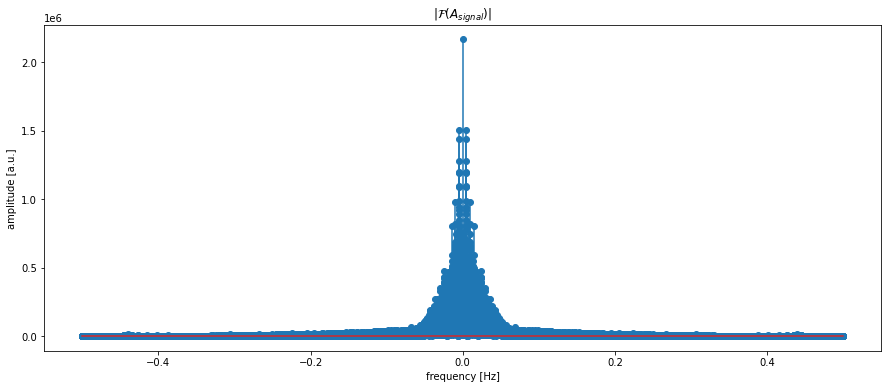

In [124]:
fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")

In [126]:
np.argmax(np.abs(A_signal_fft))

0

In [127]:
np.abs(A_signal_fft)

array([2166002.5304588 ,  137016.68862842,  115825.64474594, ...,
        127668.14886736,  115825.64474594,  137016.68862842])